In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
df = pd.read_csv('carprice.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)



In [17]:
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.msrp = pd.to_numeric(df.msrp, errors='coerce')
df.msrp = df.msrp.fillna(0)
missing = ['engine_hp', 'engine_cylinders', 'market_category', 'number_of_doors','engine_fuel_type']

for m in missing:
    df[m] = df[m].fillna(0)

In [19]:
mean_price = df['msrp'].mean()
df['above_average'] = np.where(df['msrp'] >= mean_price, 1, 0)

In [21]:
del df['msrp']

In [30]:
len(df)

11914

In [33]:
df_full_train, df_test = train_test_split(df, test_size= .2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= .25, random_state=1)

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)
df_test = df_test.reset_index(drop =True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [43]:
categorical = ['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'number_of_doors',
 'market_category',
 'vehicle_size',
 'vehicle_style']
numerical =['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
       'popularity']

In [48]:
from sklearn.metrics import roc_auc_score

# Question 1: ROC AUC feature importance
 ROC AUC could also be used to evaluate feature importance of numerical variables.

 Let's do that

- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
 If your AUC is < 0.5, invert this variable by putting "-" in front

 (e.g. -df_train['engine_hp'])

 AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [51]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < .5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673
popularity, 0.521


**Answer 1: engine_hp, 0.917**

# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [57]:
train_dicts = df_train[categorical+ numerical].to_dict(orient='records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

In [58]:
roc_auc_score(y_val, y_pred).round(3)

0.984

**Answer 2: ~= .979**

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.28
- 0.48
- 0.68
- 0.88

In [81]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [82]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [83]:
p = tp / (tp + fp)
r = tp / (tp + fn)
p, r

(1.0, 0.3730886850152905)

In [84]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9263830889856965

In [85]:
def confusion_matrix_dataframe(y_val, y_pred):
    
    thresholds= np.arange(0, 1, 0.01)
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        #p = tp / (tp + fp)
        #r = tp / (tp + fn)
        scores.append((t, tp ,fp, fn, tn))
    columns = ['threshold','tp', 'fp', 'fn', 'tn' ]
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,640,284,14,1445
20,0.2,631,194,23,1535
30,0.3,616,132,38,1597
40,0.4,597,90,57,1639
50,0.5,577,51,77,1678
60,0.6,564,37,90,1692
70,0.7,538,23,116,1706
80,0.8,494,13,160,1716
90,0.9,422,2,232,1727


In [87]:
df_scores['p'] = df_scores.tp / (df_scores.tp +df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp +df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,640,284,14,1445,0.692641,0.978593
20,0.2,631,194,23,1535,0.764848,0.964832
30,0.3,616,132,38,1597,0.823529,0.941896
40,0.4,597,90,57,1639,0.868996,0.912844
50,0.5,577,51,77,1678,0.918790,0.882263
60,0.6,564,37,90,1692,0.938436,0.862385
70,0.7,538,23,116,1706,0.959002,0.822630
80,0.8,494,13,160,1716,0.974359,0.755352
90,0.9,422,2,232,1727,0.995283,0.645260


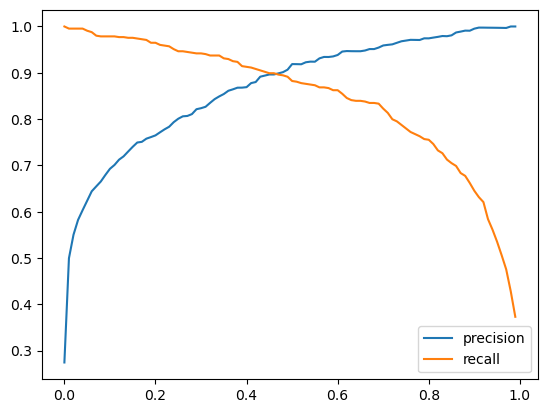

In [135]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')



plt.legend()
plt.show()
     

In [132]:
df_scores['diff'] = abs(df_scores['p'] - df_scores['r'])
intersection_thresholds = df_scores[df_scores['diff'] == df_scores['diff'].min()]['threshold']

In [133]:
intersection_thresholds = df_scores[df_scores['diff'] == df_scores['diff'].min()]['threshold']

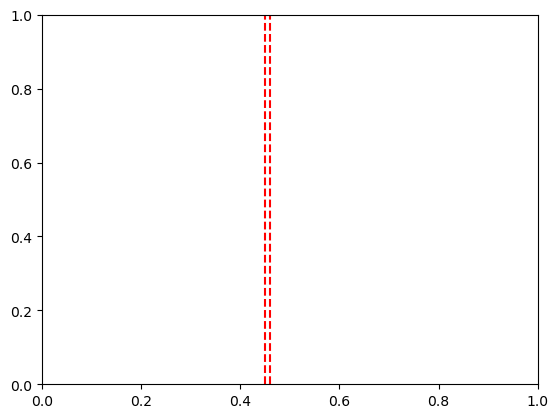

In [134]:
# Plot vertical lines at the intersection threshold(s)
for threshold in intersection_thresholds:
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Intersection at {threshold:.2f}')

**Answer 3 : 0.48**

# Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [88]:
df_scores['f1'] = 2 * df_scores['p'] * df_scores['r'] / df_scores['p'] + df_scores['r']

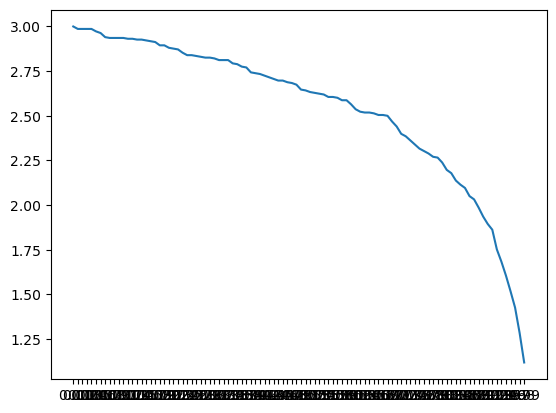

In [97]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.arange(0, 1, 0.01))
plt.show()

In [125]:
df_scores[['threshold','f1']][:13],
df_scores[['threshold','f1']][12:33]

,threshold,f1
12,0.12,2.931193
13,0.13,2.931193
14,0.14,2.926606
15,0.15,2.926606
16,0.16,2.922018
17,0.17,2.917431
18,0.18,2.912844
19,0.19,2.894495
20,0.20,2.894495
21,0.21,2.880734


**Answer 4 : 0.12**

In [106]:
def train (df_train, y_train, C=1.0):
    
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv ,model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient= 'records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X) [:,1]
    
    return y_pred

In [107]:
from sklearn.model_selection import KFold

In [115]:
scores = []

kfold = KFold(n_splits=5, shuffle= True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average
    y_val = df_val.above_average
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('%.3f +- %.3f' % ( np.mean(scores), np.std(scores)))

0.980 +- 0.003


**Answer 5 : 0.003**

# Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [127]:
kfold = KFold(n_splits=5, shuffle= True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.980 +- 0.003
C= 0.1, 0.980 +- 0.003
C= 0.5, 0.980 +- 0.003
C=  10, 0.980 +- 0.003


**Answer 6: 0.01**